<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/NLP/DZ_3_NER_Bi_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Token Classification. Практическое задание (PJ)

Для закрепления материала модуля вам необходимо решить задачу NER для предоставленного датасета, используя любые доступные вам средства. Модель должна обучаться на файле `train.txt`, валидироваться на файле `dev.txt`, а её качество необходимо оценить на файле `test.txt`.

Для достижения наилучшего результата уделите внимание подбору гиперпарметров как в плане архитектуры, так и в плане обучения модели.

Критерии оценивания проекта:

- общее качество кода и следование PEP-8;
- использование рекуррентных сетей;
- использованы варианты архитектур, близкие к state of the art для данной задачи;
- произведен подбор гиперпараметров;
- использованы техники изменения learning rate (lr scheduler);
- использована адекватная задаче функция потерь;
- использованы техники регуляризации;
- корректно проведена валидация модели;
- использованы техники ensemble;
- использованы дополнительные данные;

- итоговое значение метрики качества > 0.6 (f1)

[датасет](https://lms.skillfactory.ru/asset-v1:SkillFactory+MFTIDS+SEP2023+type@asset+block@FactRuEval.zip)

## Reading the data

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
loaded_path = '/content/data.zip'
!wget https://lms.skillfactory.ru/asset-v1:SkillFactory+MFTIDS+SEP2023+type@asset+block@FactRuEval.zip -O {loaded_path}


--2023-10-04 08:54:42--  https://lms.skillfactory.ru/asset-v1:SkillFactory+MFTIDS+SEP2023+type@asset+block@FactRuEval.zip
Resolving lms.skillfactory.ru (lms.skillfactory.ru)... 51.250.7.2
Connecting to lms.skillfactory.ru (lms.skillfactory.ru)|51.250.7.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 870425 (850K) [application/x-zip-compressed]
Saving to: ‘/content/data.zip’

/content/data.zip   100%[===================>] 850.02K  1.02MB/s    in 0.8s    

2023-10-04 08:54:44 (1.02 MB/s) - ‘/content/data.zip’ saved [870425/870425]



In [ ]:
!unzip {loaded_path}

Archive:  /content/data.zip
  inflating: dev.txt                 
  inflating: test.txt                
  inflating: train.txt               


In [ ]:
import json

def txt2json(file_path):

    save_path = f"{file_path.split('.')[0]}"+'.json'
    out_d = dict()
    with open(file_path, 'r') as in_file:

      stripped = (line.strip('\n') for line in in_file)
      line_dict = dict()

      txt = []
      lbl = []
      j = 0
      for i, line in enumerate(stripped):
        if line:
          t, l =  line.split(' ')
          txt.append(t)
          lbl.append(l)
        if not line:
          line_dict['token'] = txt
          line_dict['ner'] = lbl
          out_d.update({j: line_dict})
          txt = []
          lbl = []
          line_dict = dict()
          j+=1

    with open(save_path, 'w', encoding='utf-8') as f:
        json.dump(out_d, f, ensure_ascii=False, indent=4)





In [ ]:
txt2json('train.txt')
txt2json('dev.txt')
txt2json('test.txt')

https://github.com/urigoren/nlp_ner_workshop/tree/master/notebooks
https://colab.research.google.com/github/urigoren/nlp_ner_workshop/blob/master/notebooks/NER_with_Pytorch_Bi_LSTM.ipynb#scrollTo=pSvkcXmTzHxh

In [ ]:
import json
import collections
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(1)
from matplotlib import pyplot as plt

Our data consists of legal documents that have been pre-processed, tokenized and tagged. They're stored in one zip file of JSON files. To save space we'll read the files directly from the zip.
Let's see what one of them looks like.

Next, we'll concatenate all of these sequences into one big dataset.  
**NOTE**: Due to memory/time constraints we will limit the number of documents we use for training.

In [ ]:
# Read JSON file
def read_json(file_path):
  with open(file_path) as data_file:
      return json.load(data_file)

In [ ]:
train_sequences = read_json('train.json')
valid_sequences = read_json('dev.json')
test_sequences = read_json('test.json')

Since our RNN will work on sequences, we need to determine the maximum sequence length we'll use. The length of the sequence will impact the memory our model uses and the time it takes to train it.   
We'll choose a maximum sequence length of 256 so that almost 98% of our data will be used in the model.

In [ ]:
def filter_sequences(sequences, max_length=256):
    lengths = [len(sequences[str(i)]['token']) for i in range(len(sequences))]
    print(f'Maximum length: {max(lengths)}')
    print(f'Minimum length: {min(lengths)}')
    print(f'Average length: {sum(lengths)/len(lengths)}')

    short_sequences = []
    for i in range(len(sequences)):
      seq = sequences[str(i)]
      if len(seq['token']) <= max_length:
        short_sequences.append(seq)

    print(f'% of short sequences: {100 * len(short_sequences)/len(sequences)}')

    X = [[c for c in x['token']] for x in short_sequences] #[' '.join(c for c in x['token']) for x in short_sequences] #
    y = [[c for c in y['ner']] for y in short_sequences]
    lengths = [len(x) for x in X]
    print(f'Maximum cleared length: {max(lengths)}')
    return X, y

In [ ]:
short_sequences = []
for i in range(len(train_sequences)):
  seq = train_sequences[str(i)]
  if len(seq['token']) < 256:
    short_sequences.append(seq)

In [ ]:
max_length_allowed = 200
X_train, y_train = filter_sequences(train_sequences, max_length_allowed)
print()
X_valid, y_valid = filter_sequences(valid_sequences, max_length_allowed)
print()
X_test, y_test = filter_sequences(test_sequences, max_length_allowed)

Maximum length: 103
Minimum length: 1
Average length: 20.2285050348567
% of short sequences: 100.0
Maximum cleared length: 103

Maximum length: 207
Minimum length: 2
Average length: 19.824167312161116
% of short sequences: 99.96127033307513
Maximum cleared length: 150

Maximum length: 222
Minimum length: 2
Average length: 20.541440743609606
% of short sequences: 99.96127033307513
Maximum cleared length: 116


In [ ]:
j = 10
len(X_valid[j]), len(y_valid[j])


(12, 12)

## Encoding the sequences

Now that we have our word sequences ready we need to represent them in a machine readable (=numerical) format. To do that, we'll merge all of the tokens into one big corpus and assign each token a unique number.  
**NOTE**: We will remove words that appear less than `min_token_frequency` since we can't learn much from them.

In [ ]:
import collections

In [ ]:
min_token_frequency = 2
ALL = X_train + X_valid
corpus = (token for sequence in ALL for token in sequence)

## Reserve the first two indexes for padding and uknowns
index2token = ["{unk}"] + [token for token, count in collections.Counter(corpus).items() if count >= min_token_frequency]
token2index = collections.defaultdict(lambda: 1, {token: index for index, token in enumerate(index2token)})

index2label = list(set([label for target in y_train for label in target]))
label2index = {label: index for index, label in enumerate(index2label)}


In [ ]:
index2label

['B-LOC', 'B-PER', 'B-ORG', 'I-LOC', 'O', 'I-PER', 'I-ORG']

In [ ]:
label2index

{'B-LOC': 0,
 'B-PER': 1,
 'B-ORG': 2,
 'I-LOC': 3,
 'O': 4,
 'I-PER': 5,
 'I-ORG': 6}

Let's see some stats about our data

In [ ]:
max_sequence_length = max([len(x) for x in ALL])

NUM_CLASSES = len(label2index)

print('Text vocabulary size: ', len(token2index))
print('Label vocabulary size: ', NUM_CLASSES)
print('Maximum sequence length: ', max_sequence_length)

Text vocabulary size:  43026
Label vocabulary size:  7
Maximum sequence length:  150


Next, we will use the dictionaries we've just created to encode our data.  
**NOTE**: padding is not required as every exemple as its own model. If we decide to pad it may improve the performance, but we pad each batch individually.

In [ ]:
X_enc_train = [[token2index[token] for token in sequence] for sequence in X_train]
y_enc_train = [[label2index[label] for label in target] for target in y_train]

X_enc_valid = [[token2index[token] for token in sequence] for sequence in X_valid]
y_enc_valid = [[label2index[label] for label in target] for target in y_valid]

X_enc_test = [[token2index[token] for token in sequence] for sequence in X_test]
y_enc_test = [[label2index[label] for label in target] for target in y_test]

In [ ]:
j = 10
len(X_enc_valid[j]), len(y_enc_valid[j])


(12, 12)

## Building the model

Before building our model, let's define some parameters which we'll need later

In [ ]:
vocabulary_size = len(token2index)
tags_size = NUM_CLASSES
embedding_size = 128
hidden_size = 128
batch_size = 2048
epochs = 5

To build our LSTM RNN, we're going to use Pytorch. We'll build it one layer at a time, explaining each layer as we go.
This is an auxiliary function.



In [ ]:
def prepare_sequence(seq):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    return torch.tensor(seq, dtype=torch.long).to(device)

In [ ]:
prepare_sequence(X_enc_valid[0])

tensor([195, 395, 396, 397, 398, 399,  33, 400, 248,   8, 401, 402, 403, 404,
        405, 406, 248,  36])

In [ ]:

class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size,
                                            embedding_dim)  # lookup table that switch word (word index) with vector

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(2 * hidden_dim,
                                    tagset_size)  # 2 times the hidden size due to the concatanation of the direction
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        return (autograd.Variable(torch.zeros(2, 1, self.hidden_dim).to(device)),
                autograd.Variable(
                    torch.zeros(2, 1, self.hidden_dim).to(device)))  # <- change here: first dim of hidden needs to be doubled

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        return tag_space

    def predict(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        logits = self.hidden2tag(lstm_out.view(len(sentence), -1))
        pred = torch.softmax(logits, dim=1)
        pred = torch.argmax(pred, dim=1)
        return pred


In [ ]:
model = LSTMTagger(embedding_size,hidden_size,vocabulary_size,tags_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LSTMTagger(
  (word_embeddings): Embedding(35630, 128)
  (lstm): LSTM(128, 128, bidirectional=True)
  (hidden2tag): Linear(in_features=256, out_features=7, bias=True)
)

In [ ]:
def eval_on_dev(X_dev,y_dev):
    sum_loss = 0.0
    good = 0.0
    bad = 0.0
    ### Testing
    model.eval()
    for sentence_in, targets in zip(X_dev,y_dev):
      # Step 1. Remember that Pytorch accumulates gradients.
      # We need to clear them out before each instance

      # Also, we need to clear out the hidden state of the LSTM,
      # detaching it from its history on the last instance.
      model.hidden = model.init_hidden()

      # Step 3. Run our forward pass.
      logits = model(prepare_sequence(sentence_in))

      # Step 4. Compute the loss, gradients, and update the parameters by
      targets = prepare_sequence(targets)
      loss = loss_function(logits, targets)
      preds = torch.softmax(logits, dim=1)
      preds = torch.argmax(preds, dim=1)

      sum_loss += loss.item()
      correct = (preds == targets).sum().item()
      good += correct
      bad  += len(targets) - correct

    return sum_loss/len(X_dev), good / (good + bad)



## Training the model

In [ ]:
eval_number = 1000
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
loss_history = []
dev_history = []
dev_acc_history = []
sum_loss = 0.0

reduce_train_size = 2
stop = int(len(X_enc_train)/reduce_train_size)

for epoch in range(epochs):
    i = 0
for epoch in range(epochs):
    print(f'\nTrain on epoch {epoch+1}')
    for sentence_in, targets in zip(X_enc_train[:stop], y_enc_train[:stop]):
        i+=1
         #every eval_number check you accuracy and loss on the dev set
        if (i % eval_number == 0):
            t = 100 * i/(epochs*stop)
            loss_history.append(sum_loss / eval_number)
            dev_loss, dev_acc = eval_on_dev(X_enc_valid, y_enc_valid)
            dev_history.append(dev_loss)
            dev_acc_history.append(dev_acc)
            print(f'{t:.2f}% train with loss {sum_loss / eval_number:.4f} |   val_loss {dev_loss:.4f}, val_acc {dev_acc:.4f}')
            sum_loss = 0.0

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()
        #model.train()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 3. Run our forward pass.
        tag_scores = model(prepare_sequence(sentence_in))

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step(
        targets = prepare_sequence(targets)
        loss = loss_function(tag_scores, targets)

        sum_loss += loss.item()
        loss.backward()
        optimizer.step()






Train on epoch 1
5.16% train with loss 0.6121 |   val_loss 0.5640, val_acc 0.8503
10.33% train with loss 0.5549 |   val_loss 0.5132, val_acc 0.8590
15.49% train with loss 0.4859 |   val_loss 0.4577, val_acc 0.8688

Train on epoch 2
20.66% train with loss 0.4299 |   val_loss 0.4233, val_acc 0.8761
25.82% train with loss 0.4007 |   val_loss 0.4126, val_acc 0.8811
30.98% train with loss 0.3610 |   val_loss 0.3753, val_acc 0.8870
36.15% train with loss 0.3241 |   val_loss 0.3568, val_acc 0.8930

Train on epoch 3
41.31% train with loss 0.3033 |   val_loss 0.3343, val_acc 0.8971
46.48% train with loss 0.2851 |   val_loss 0.3221, val_acc 0.9007
51.64% train with loss 0.2428 |   val_loss 0.3109, val_acc 0.9068
56.80% train with loss 0.2187 |   val_loss 0.2926, val_acc 0.9115

Train on epoch 4
61.97% train with loss 0.2069 |   val_loss 0.2866, val_acc 0.9119
67.13% train with loss 0.1922 |   val_loss 0.3144, val_acc 0.8996
72.30% train with loss 0.1651 |   val_loss 0.2864, val_acc 0.9081
77.46

Let's examine the learning process

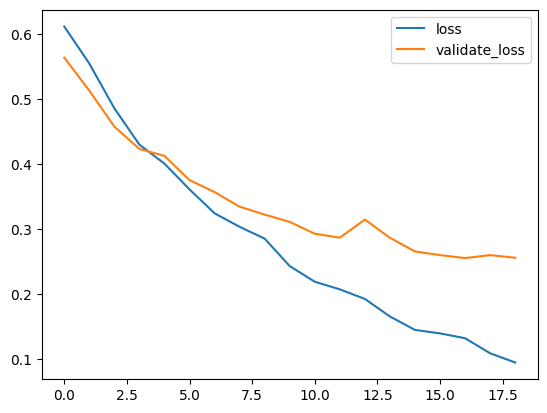

In [ ]:
# plot some data
plt.plot(loss_history, label='loss')
plt.plot(dev_history, label='validate_loss')
plt.legend();

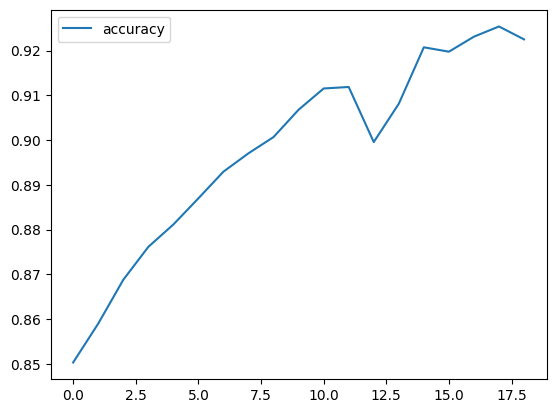

In [ ]:
# accuracies
plt.plot(dev_acc_history, label='accuracy')
plt.legend();

## Test


In [ ]:
test_loss, test_acc = eval_on_dev(X_enc_test, y_enc_test)
test_loss, test_acc

(0.24495130375448473, 0.9242464404725841)

In [ ]:
preds = []
for sentence_in in X_enc_test:
    model.eval()
    model.hidden = model.init_hidden()

    # Step 3. Run our forward pass.
    logits = model(prepare_sequence(sentence_in))

    # Step 4. Compute the loss, gradients, and update the parameters by
    targets = prepare_sequence(targets)
    pred = torch.softmax(logits, dim=1)
    pred = torch.argmax(pred, dim=1)
    preds.append(pred.cpu().numpy())

#preds = [[index2label[y_] for y_ in y] for y in preds]

<ipython-input-119-039af80a889d>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(seq, dtype=torch.long).to(device)


In [ ]:
correct  = 0
incorrect = 0
for i in range(len(X_enc_test)):
  y_pred = preds[i]
  y_true = np.array(y_enc_test[i])
  correct += np.nonzero(y_pred == y_true)[0].shape[0]
  incorrect += np.nonzero(y_pred != y_true)[0].shape[0]

print("Correct predicted classes:", correct)
print("Incorrect predicted classes:", incorrect)
print(correct / (correct + incorrect))

Correct predicted classes: 48815
Incorrect predicted classes: 4001
0.9242464404725841


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def flat_lists(seqs):
  out = []
  for s in seqs:
    out.extend(s)
  return out

In [ ]:
print(classification_report(flat_lists(y_enc_test), flat_lists(preds), target_names=index2label))

              precision    recall  f1-score   support

       B-LOC       0.84      0.75      0.79      1508
       B-PER       0.64      0.67      0.65      2132
       B-ORG       0.78      0.60      0.68      1734
       I-LOC       0.88      0.65      0.75       342
           O       0.95      0.97      0.96     44706
       I-PER       0.76      0.70      0.73      1304
       I-ORG       0.68      0.48      0.57      1090

    accuracy                           0.92     52816
   macro avg       0.79      0.69      0.73     52816
weighted avg       0.92      0.92      0.92     52816

